## Programming Exercise 4: Neural Networks Learning

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io 
import scipy.misc 
import matplotlib.cm as cm 
import random 
import scipy.optimize 
import itertools
from scipy.special import expit 
import warnings
warnings.filterwarnings("ignore") 

### 1 Neural Networks

#### 1.1 Visualizing the data

In [6]:
datafile = 'E:\\BaiduYunDownload\\Andrew NG\\machinelearning.ai\\教程和笔记\\Stanford-Machine-Learning-Course-master\\Neural network learning\\mlclass-ex4\\ex4data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1)
print("'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y'])))
print("'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape))

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [7]:
def getDatumImg(row):
    """
    传递形状为1x400的单个np数组的函数，
    从中创建一个图像对象，然后返回
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X中选取100个随机行的函数，从每个行创建一个20x20的图像，
    然后将它们拼接成10x10网格图像，并显示出来。
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

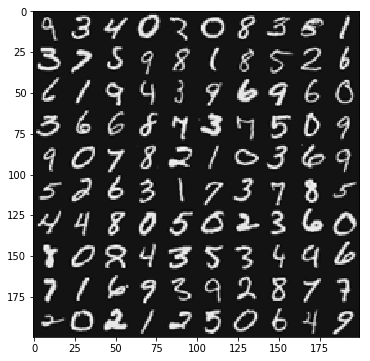

In [8]:
displayData()

#### 1.2 Model representation

In [10]:
# 您已经获得了一组网络参数（Θ（1），Θ（2））
# 这些存储在ex4weights.mat中

datafile = 'E:\\BaiduYunDownload\\Andrew NG\\machinelearning.ai\\教程和笔记\\Stanford-Machine-Learning-Course-master\\Neural network learning\\mlclass-ex4\\ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']

#矩阵Theta1和Theta2现在将在您的工作区中
# Theta1的尺寸为25 x 401
# Theta2的尺寸为10 x 26

In [11]:
#这些是我正在起诉的一些全局变量，以确保尺寸
#各种矩阵的＃是正确的
#these不包括偏置单元

input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [14]:
#一些实用程序功能。
#扁平化和输入X矩阵等...
#很好形状的矩阵使线性代数在开发时更容易，
#但最小化例程（fmin_cg）要求所有输入

def flattenParams(thetas_list):
    """
    将此函数作为theta矩阵的列表，并将其展平
    成一个长（n，1）形的numpy阵列
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

#### 1.3 Feedforward and cost function

In [17]:
def computeCost(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    """
    此功能包括：
        
    1）theta参数的平面向量（每个theta将从1开始NN层到下一个），其中包括偏置单元。
        
    2）展平训练集矩阵X，其包含偏置单元第一列
        
    3）标签向量y，其具有一列它循环在训练点上（由教授推荐，作为线性代数版本“非常复杂”）的和
        
    1）构造一个新的“y”向量，包含10行和1列，具有对应于该迭代的一个非零条目
        
    2）计算给定y-向量和训练点的成本
        
    3）积累所有损失值
        
    4）计算正则化项（在训练点循环之后）
    """
    
    # 首先展开参数
    mythetas = reshapeParams(mythetas_flattened)
    
    # 现在展开X
    myX = reshapeX(myX_flattened)
    
    # 这就是将积累的全部损失值This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples

    # 循环遍历训练点（myX中的行，已包含偏置单位）
    for irow in range(m):
        myrow = myX[irow]
                
    #首先计算假设（这是一个（10,1）向量
    #每个可能的y值的假设＃）
    #方向传播算法为每个图层返回（zs，激活）
    #所以方向传播[-1] [1]表示“激活-1st（最后）层”
        myhs = propagateForward(myrow,mythetas)[-1][1]

    #构造一个10x1“y”向量，其中包含全零和仅一个“1”条目       
    #注意如果手写数字为“0”，则对应到y-向量，在第10个点有1个（不同于homework暗示）
        tmpy  = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        
        # 计算此点和y向量的损失值
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # 累计总损失值
        total_cost += mycost
  
    # 正则化全部损失值，强制转换为浮点值
    total_cost = float(total_cost) / m
    
    # 乘以正则化项
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    给出Thetas列表（未展平）的函数传播一系列功能向前，假设功能已成功包括输入层中的偏置单元，以及Thetas还包括偏置单元
    输出是一个带有元素[0]的向量，用于隐藏层和元素[1]用于输出层
        
    - 每个元素都是（zs，as）的元组     
    - “zs”和“as”具有形状（该层中的单位数，1）
     
    ***'激活'与“h”相同，但这适用于许多层（因此是thetas的矢量，而不仅仅是一个theta）    
    此外，“h”被矢量化以一次完成所有行...    
    这个函数一次只占一行***
    """
   
    features = row
    zs_as_per_layer = []
    for i in range(len(Thetas)):  
        Theta = Thetas[i]
        #Theta是（25,401），功能是（401,1）        
        #so“z”出来是（25,1）       
        #this是隐藏层中每个单元的一个“z”值       
        #不计算偏差单位
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) # 加上偏置单元
        features = a

In [20]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
myThetas = [ Theta1, Theta2 ]

#注意我在将它传递给computeCost例程之前展平了thetas向量，

# 作为每一次乘以损失函数的输入格式。

# 它进行展开/重塑本身

# 同样，＃I也平整了X向量
print(computeCost(flattenParams(myThetas),flattenX(X),y))

0.28762916516131876


#### 1.4 Regularized cost function

In [22]:
#一旦完成了使用加载的参数集Theta1和Theta2，lambda = 1,成本约为0.383770

myThetas = [ Theta1, Theta2 ]
print(computeCost(flattenParams(myThetas),flattenX(X),y,mylambda=1.))

0.3844877962428938


### 2 Backpropagation

#### 2.1 Sigmoid gradient

In [23]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

#### 2.2 Random initialization

In [24]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation


In [25]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # 现在展开X
    myX = reshapeX(myX_flattened)

    #注意：Delta矩阵应包括偏置单元
    
    #Delta矩阵与theta矩阵具有相同的形状
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # 循环遍历训练点（myX中的行，已包含偏置单位）
    m = n_training_samples
    for irow in range(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #正则化:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [26]:
# 实际为所提供的Thetas计算D矩阵
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.)
D1, D2 = reshapeParams(flattenedD1D2)

#### 2.4 Gradient checking

In [28]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
# 挑选十个随机元素，计算数值梯度，与各自的D进行比较
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print("Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x]))

In [29]:
checkGradient(myThetas,[D1, D2],X,y)

Element: 384. Numerical Gradient = -0.000002. BackProp Gradient = -0.000002.
Element: 652. Numerical Gradient = 0.000104. BackProp Gradient = 0.000104.
Element: 7576. Numerical Gradient = -0.000003. BackProp Gradient = -0.000003.
Element: 2226. Numerical Gradient = -0.000003. BackProp Gradient = -0.000003.
Element: 9057. Numerical Gradient = 0.000038. BackProp Gradient = 0.000038.
Element: 4620. Numerical Gradient = -0.000334. BackProp Gradient = -0.000334.
Element: 1286. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.
Element: 2221. Numerical Gradient = -0.000408. BackProp Gradient = -0.000408.
Element: 5778. Numerical Gradient = -0.000052. BackProp Gradient = -0.000052.
Element: 3246. Numerical Gradient = -0.000000. BackProp Gradient = -0.000000.


#### 2.5 Regularized Neural Networks

In [34]:
#我的反向传播已经有了正规化。

#现在，我将假设正则化部分是正确的

#（因为在这种情况下，正则化代码很简单，我很自信）

#### 2.5 Learning parameters using fmincg

In [32]:
#这里要用scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    生成随机初始theta矩阵的函数，优化它们，并返回两个重新形成的theta矩阵的列表
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=50,disp=True,full_output=True)
    return reshapeParams(result[0])

In [37]:
# 在我的机器上训练NN大约需要127秒，4核
%time learned_Thetas = trainNN()

         Current function value: 0.244604
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111
Wall time: 2min 7s


In [38]:
# 如果您的实施是正确的，您应该看到报告的培训准确率约为95.3％（由于随机初始化，这可能会变化约1％）。

In [44]:
def predictNN(row,Thetas):
    """
    占用一行特征的函数，通过它传播NN，并返回手写的预测整数
    """
    classes = [x for x in range(1,10)] + [10]
    output = propagateForward(row,Thetas)
    #-1表示最后一层，1表示“a”而不是“z”
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
   循环遍历X中所有行的函数（所有手写图像）并预测给定的数字写入的数字。检查它是否正确，并且计算效率。
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in range(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print("Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total)))

In [45]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 97.3%


In [47]:
#让我们看看我是否将lambda设置为10，如果我得到同样的东西
%time learned_regularized_Thetas = trainNN(mylambda=10.)

         Current function value: 1.078448
         Iterations: 50
         Function evaluations: 120
         Gradient evaluations: 120
Wall time: 2min 12s


In [48]:
%time computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 92.9%
Wall time: 341 ms


### 3 Visualizing the hidden layer

In [49]:
def displayHiddenLayer(myTheta):
    """
    获取第一个Theta矩阵的切片的函数（来自输入层到隐藏层），删除偏置单元，并重塑形状
    它变成了20x20的图像，然后显示出来
    """
    #移除偏差单元:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        # 添加偏置单位？
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

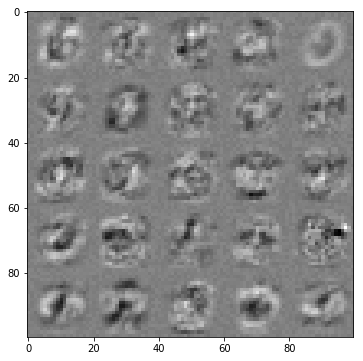

In [52]:
displayHiddenLayer(learned_Thetas[0])